In [1]:
%matplotlib inline
import matplotlib
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from tqdm import tqdm_notebook
import io
from PIL import Image
from glob import glob
from collections import defaultdict
import os
import pickle
from io import BytesIO
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

from kaggle_camera_model_id_lib.utils import PechkaBot, ImageList, NpzFolder, NCrops, TifFolderExFiles
from kaggle_camera_model_id_lib.models import VggHead, StyleVggHead, IEEEfcn, ResNetFC
from kaggle_camera_model_id_lib.utils import jpg_compress, equalize_v_hist, hsv_convert
from kaggle_camera_model_id_lib.utils import scale_crop_pad, gamma_correction

from sklearn.manifold import TSNE

from scipy.spatial.distance import pdist, squareform

In [2]:
model_factory = {
    'Vgg19Head_E_2b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_2b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_3b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_3b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='E', batch_norm=True),
    'Vgg11Head_A_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=True),
    'Vgg11Head_A': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=False),
    'StyleVggHead_bn': lambda n_classes: StyleVggHead(num_classes=n_classes, load_vgg_bn=True),
    'IEEEfcn': lambda n_classes: IEEEfcn(n_classes),
    'resnet18fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'resnet18fc': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet=None),
    'resnet18X_pretrained': lambda n_classes: ResNetX(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'InceptionResNetV2fc_5_10_4': lambda n_classes: InceptionResNetV2fc(
        num_classes=n_classes, nun_block35=5, num_block17=10, num_block8=4),
    'InceptionResNetV2fcSmall_5_10': lambda n_classes: InceptionResNetV2fcSmall(
        num_classes=n_classes, nun_block35=5, num_block17=10),
    'resnet34fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34'),
    'resnet50fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet50')
}

In [3]:
test_path = '/home/mephistopheies/storage2/data/camera-model-id/raw/test/'
model_path = '/home/mephistopheies/storage2/data/camera-model-id/models/resnet34fc/256_pretrained_random_aug_kaggle_10/best_model.tar'
out_dir = '/home/mephistopheies/storage2/data/camera-model-id/submit/'
model_type = 'resnet34fc_pretrained'
n_classes = 10
crop_size = 256
step = 128
batch_size = 5
num_workers = 1

to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

model = model_factory[model_type](n_classes)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])
loss_train = checkpoint['loss_train']
acc_train = checkpoint['acc_train']
loss_val = checkpoint['loss_val']
acc_val = checkpoint['acc_val']
class_to_idx = checkpoint['class_to_idx']
idx2class = dict([(v, k) for (k, v) in class_to_idx.items()])
print('Last state:\n  TLoss: %0.6f\n  TAcc:  %0.4f\n  VLoss: %0.6f\n  VAcc:  %0.4f' % 
    (loss_train[-1], acc_train[-1], loss_val[-1], acc_val[-1]))
del(checkpoint)
model = model.cuda()
model = model.eval()

Last state:
  TLoss: 0.014845
  TAcc:  0.9951
  VLoss: 0.100587
  VAcc:  0.9674


In [4]:
ds_test = TifFolderExFiles(
    test_path,
    transform=transforms.Compose([
        transforms.Lambda(lambda img: NCrops(np.array(img), crop_size=crop_size, step=step)),
        transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(crop)) for crop in crops]))
    ]))

test_loader = torch.utils.data.DataLoader(    
    ds_test,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers, 
    pin_memory=True)

res = []
p_test = {}
for X, Y, files in tqdm_notebook(test_loader, total=int(len(ds_test.imgs)/batch_size)):
    files = list(map(lambda s: os.path.basename(s), files))
    bs, ncrops, c, h, w = X.shape
    X = X.view(-1, c, h, w)
    X_var = Variable(X.cuda(), volatile=True)
    log_p = model(X_var)
    log_p = log_p.view(bs, ncrops, -1)
    p = F.softmax(log_p, dim=2) #.mean(dim=1)
    p = p.prod(dim=1).pow(1/p.shape[1])
    ix_argmax = p.max(1)[1].cpu().data.numpy()
    res.extend(list(zip(files, [idx2class[ix] for ix in ix_argmax])))

    for ix in range(len(files)):
        p_test[files[ix]] = [(idx2class[i], x) for (i, x) in enumerate(p[ix, :].cpu().data.numpy())]

In [5]:
manip = [(f, c) for (f, c) in p_test.items() if '_manip' in f]
print(len(p_test), len(manip))

del(model)

2640 1320


In [7]:
test_path = '/home/mephistopheies/storage2/data/camera-model-id/raw/test/'
model_path = '/home/mephistopheies/storage2/data/camera-model-id/models/Vgg19Head_E_2b_bn__bak/256_do_random_aug_kaggle_05/best_model.tar'
out_dir = '/home/mephistopheies/storage2/data/camera-model-id/submit/'
model_type = 'Vgg19Head_E_2b_bn'
n_classes = 10
crop_size = 256
step = 128
batch_size = 5
num_workers = 1

to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

model = model_factory[model_type](n_classes)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])
loss_train = checkpoint['loss_train']
acc_train = checkpoint['acc_train']
loss_val = checkpoint['loss_val']
acc_val = checkpoint['acc_val']
class_to_idx = checkpoint['class_to_idx']
idx2class = dict([(v, k) for (k, v) in class_to_idx.items()])
print('Last state:\n  TLoss: %0.6f\n  TAcc:  %0.4f\n  VLoss: %0.6f\n  VAcc:  %0.4f' % 
    (loss_train[-1], acc_train[-1], loss_val[-1], acc_val[-1]))
del(checkpoint)
model = model.cuda()
model = model.eval()

Last state:
  TLoss: 0.258575
  TAcc:  0.9264
  VLoss: 0.209841
  VAcc:  0.9442


In [8]:
ds_test = TifFolderExFiles(
    test_path,
    transform=transforms.Compose([
        transforms.Lambda(lambda img: NCrops(np.array(img), crop_size=crop_size, step=step)),
        transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(crop)) for crop in crops]))
    ]))

test_loader = torch.utils.data.DataLoader(    
    ds_test,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers, 
    pin_memory=True)

res = []
p_test = {}
for X, Y, files in tqdm_notebook(test_loader, total=int(len(ds_test.imgs)/batch_size)):
    files = list(map(lambda s: os.path.basename(s), files))
    bs, ncrops, c, h, w = X.shape
    X = X.view(-1, c, h, w)
    X_var = Variable(X.cuda(), volatile=True)
    log_p = model(X_var)
    log_p = log_p.view(bs, ncrops, -1)
    p = F.softmax(log_p, dim=2) #.mean(dim=1)
    p = p.prod(dim=1).pow(1/p.shape[1])
    ix_argmax = p.max(1)[1].cpu().data.numpy()
    res.extend(list(zip(files, [idx2class[ix] for ix in ix_argmax])))

    for ix in range(len(files)):
        p_test[files[ix]] = [(idx2class[i], x) for (i, x) in enumerate(p[ix, :].cpu().data.numpy())]

In [9]:
unalt = [(f, c) for (f, c) in p_test.items() if '_unalt' in f]
print(len(p_test), len(unalt))

del(model)

2640 1320


In [10]:
unalt_tmp = unalt.copy()
manip_tmp = manip.copy()
print(len(unalt_tmp), len(manip_tmp))

t = int(0.1*1320)
print(t)

res = []

c_counts = defaultdict(int)
for _ in range(1320):
    skip_f = set([k for (k, _) in res])
    unalt_tmp = [(f, sorted(p, key=lambda t: t[-1], reverse=True)) for (f, p) in unalt_tmp if f not in skip_f]
    unalt_tmp = sorted(unalt_tmp, key=lambda t: t[-1][0], reverse=True)
    f, p = unalt_tmp[0]
    c, _ = p[0]
    res.append((f, c))
    c_counts[c] += 1
    
    if c_counts[c] == t:
        unalt_tmp = [(f, [(k, v) for (k, v) in p if k != c]) for (f, p) in unalt_tmp]
        
c_counts = defaultdict(int)
for _ in range(1320):
    skip_f = set([k for (k, _) in res])
    manip_tmp = [(f, sorted(p, key=lambda t: t[-1], reverse=True)) for (f, p) in manip_tmp if f not in skip_f]
    manip_tmp = sorted(manip_tmp, key=lambda t: t[-1][0], reverse=True)
    f, p = manip_tmp[0]
    c, _ = p[0]
    res.append((f, c))
    c_counts[c] += 1
    
    if c_counts[c] == t:
        manip_tmp = [(f, [(k, v) for (k, v) in p if k != c]) for (f, p) in manip_tmp]
        
print(len(res))

1320 1320
132
2640


In [11]:
with open(os.path.join(out_dir, 'submit__unalt.csv'.lower()), 'w') as f:
    f.write('fname,camera\n')
    for fname, c in res:
        if '_unalt' in fname:
            f.write('%s,%s\n' % (fname, c))
        else:
            f.write('%s,%s\n' % (fname, 'no_class'))
            
            
with open(os.path.join(out_dir, 'submit__manip.csv'.lower()), 'w') as f:
    f.write('fname,camera\n')
    for fname, c in res:
        if '_manip' in fname:
            f.write('%s,%s\n' % (fname, c))
        else:
            f.write('%s,%s\n' % (fname, 'no_class'))
            
            
with open(os.path.join(out_dir, 'submit.csv'.lower()), 'w') as f:
    f.write('fname,camera\n')
    for fname, c in res:
        f.write('%s,%s\n' % (fname, c))

In [122]:
# metric : str or function, optional
#     The distance metric to use. The distance function can
#     be 'braycurtis', 'canberra', 'chebyshev', 'cityblock',
#     'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
#     'jaccard', 'kulsinski', 'mahalanobis', 'matching',
#     'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
#     'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'.

In [83]:
m = np.vstack([np.array([[v for (k, v) in p] for (_, p) in manip]), np.array([[v for (k, v) in p] for (_, p) in unalt])])

In [133]:
tsne = TSNE(n_components=2, n_iter=1000,  metric='euclidean', verbose=True)
m_tsne = tsne.fit_transform(m)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2640 samples in 0.003s...
[t-SNE] Computed neighbors for 2640 samples in 0.168s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2640
[t-SNE] Computed conditional probabilities for sample 2000 / 2640
[t-SNE] Computed conditional probabilities for sample 2640 / 2640
[t-SNE] Mean sigma: 0.000131
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.965454
[t-SNE] Error after 1000 iterations: 0.432948


In [101]:
pal = sns.color_palette("hls", 10)

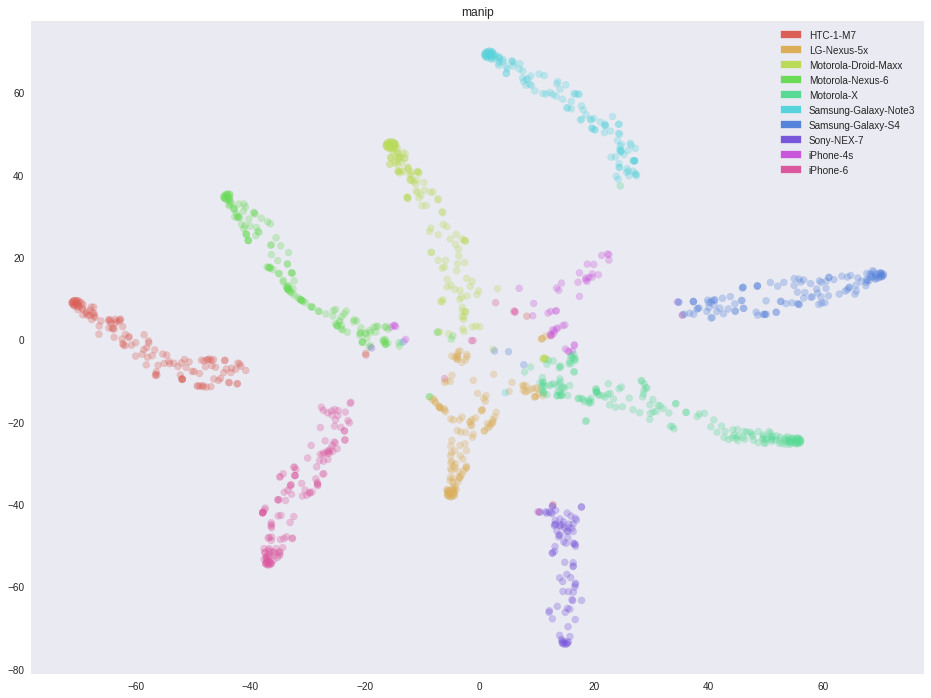

In [151]:
plt.title('manip')
plt.scatter(m_tsne[:1320, 0], m_tsne[:1320, 1], 
            c=[pal[class_to_idx[sorted(p, key=lambda t: t[-1], reverse=True)[0][0]]] for (f, p) in manip],
            alpha=0.3)

plt.legend(handles=[mpatches.Patch(color=pal[i], label=idx2class[i]) for i in range(10)])

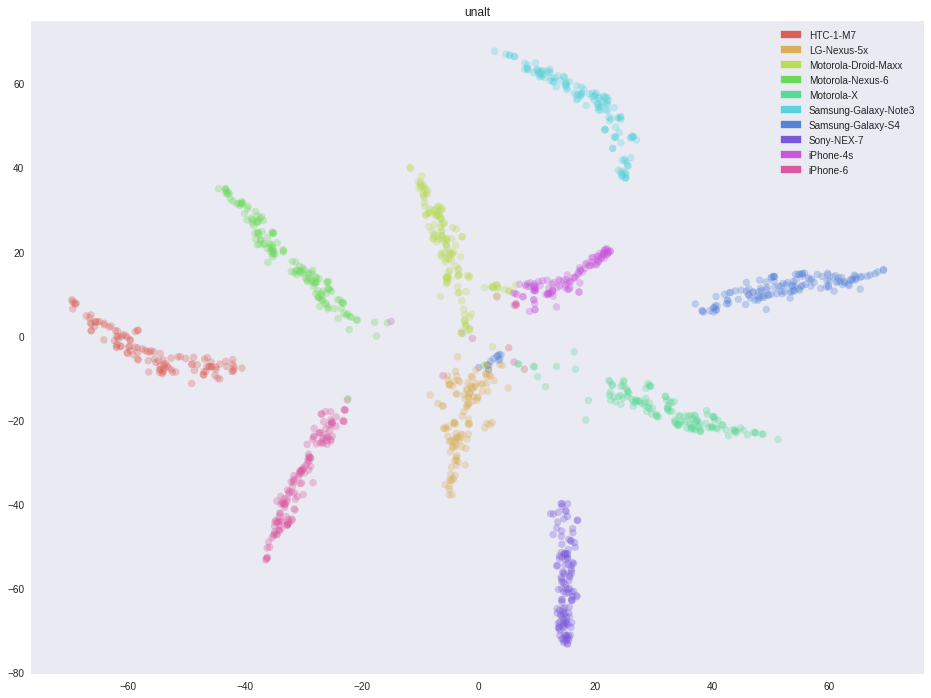

In [150]:
plt.title('unalt')
plt.scatter(m_tsne[1320:, 0], m_tsne[1320:, 1], 
            c=[pal[class_to_idx[sorted(p, key=lambda t: t[-1], reverse=True)[0][0]]] for (f, p) in unalt],
            alpha=0.3)

plt.legend(handles=[mpatches.Patch(color=pal[i], label=idx2class[i]) for i in range(10)])

In [136]:
m_tsne.shape

(2640, 2)

In [147]:
d = squareform(pdist(m_tsne, metric='euclidean'))

In [148]:
d

array([[   0.        ,  112.10472359,   92.87961223, ...,  112.16293198,
          13.14487621,   40.37533279],
       [ 112.10472359,    0.        ,   88.68185062, ...,    3.38765486,
         103.24571697,   75.51471477],
       [  92.87961223,   88.68185062,    0.        , ...,   91.43394944,
          94.99864073,   61.32627921],
       ..., 
       [ 112.16293198,    3.38765486,   91.43394944, ...,    0.        ,
         103.00254172,   76.22006339],
       [  13.14487621,  103.24571697,   94.99864073, ...,  103.00254172,
           0.        ,   36.87109235],
       [  40.37533279,   75.51471477,   61.32627921, ...,   76.22006339,
          36.87109235,    0.        ]])